In [1]:
import numpy as np
import os
import pandas as pd
from skimage import io
from skimage import color, exposure, transform
from PIL import Image 
import cv2
import matplotlib
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage import exposure

import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Convolution2D 
from keras.layers import Input, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.utils import np_utils 

from keras.preprocessing.image import ImageDataGenerator
from sklearn.cross_validation import train_test_split

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

Using TensorFlow backend.
/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def analyse_images(imgs_paths):
    
    data = []
    i = 0

    for img_path in imgs_paths:
        img_class = int(img_path.split('/')[-2])
        
        img = io.imread(img_path)
        
        """"
        print "ORIGINAL IMAGE:"
        plt.imshow(img,aspect="auto")
        plt.show()
        print '\n'
        """

        rows,col = (img.shape[:2])
        if rows>col:
            new_side = col
        else:
            new_side = rows
        
        srows =  rows//2-new_side//2
        frows =  rows//2+new_side//2
        
        scol =  col//2-new_side//2
        fcol =  col//2+new_side//2
        
        img = img[srows:frows,scol:fcol,:]

        # rescale to standard size
        img = transform.resize(img, (48, 48))
        
        # Contrast stretching
        p2, p98 = np.percentile(img, (2, 98))
        img_contrast = exposure.rescale_intensity(img, in_range=(p2, p98))


        # Histogram Equalization
        img_eq = exposure.equalize_hist(img)

        # Adaptive Equalization
        img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.01)

        """
        print "RESCALED IMAGE:"
        plt.imshow(img,aspect="auto")
        plt.show()
        print '\n'
        
        print "CONTRAST STRETCHING IMAGE:"
        plt.imshow(img_contrast,aspect="auto")
        plt.show()
        print '\n'
        
        print "HISTOGRAM EQUATION IMAGE:"
        plt.imshow(img_eq,aspect="auto")
        plt.show()
        print '\n'
        
        print "ADAPTIVE EQUATION IMAGE:"
        plt.imshow(img_adapteq,aspect="auto")
        plt.show()
        print '\n'
        """
        
        data.append([img_eq,img_class])
        
        i = i+1
        
        if ((i % 1000)== 0):
            print ("Images processed: ")+str(i)
        
    return data




In [3]:
directory = 'GTSRB/Final_Training/Images/'
imgs = []
labels = []
paths = []
number_signs = 0

for sub_dir in os.listdir(directory):
    sd = directory+sub_dir+'/'
    if (sub_dir != ".DS_Store"):
        number_signs = number_signs+1
        for files in os.listdir(sd):
            if (files.endswith(".csv")==False):
                paths.append(directory+sub_dir+'/'+files)



np.random.shuffle(paths)
data = analyse_images(paths)
elements = []
classes = []
for d in data:
    elements.append(d[0])
    classes.append(d[1])

/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Images processed: 1000
Images processed: 2000
Images processed: 3000
Images processed: 4000
Images processed: 5000
Images processed: 6000
Images processed: 7000
Images processed: 8000
Images processed: 9000
Images processed: 10000
Images processed: 11000
Images processed: 12000
Images processed: 13000
Images processed: 14000
Images processed: 15000
Images processed: 16000
Images processed: 17000
Images processed: 18000
Images processed: 19000
Images processed: 20000
Images processed: 21000
Images processed: 22000
Images processed: 23000
Images processed: 24000
Images processed: 25000
Images processed: 26000
Images processed: 27000
Images processed: 28000
Images processed: 29000
Images processed: 30000
Images processed: 31000
Images processed: 32000
Images processed: 33000
Images processed: 34000
Images processed: 35000
Images processed: 36000
Images processed: 37000
Images processed: 38000
Images processed: 39000


In [16]:
def cnn_model(height,width,depth,number_signs):
    
    
    inp = Input(shape=(height, width, depth))
    
    act= keras.layers.advanced_activations.LeakyReLU(alpha=0.001)
    #act = keras.layers.advanced_activations.ELU(alpha=0.001)
    conv_1 = Convolution2D(32, (3, 3), padding='same', activation=act)(inp)
    conv_2 = Convolution2D(32, (3, 3), padding='same', activation=act)(conv_1)
    
    pool_1 = MaxPooling2D((2, 2), data_format="channels_last")(conv_2)
    drop_1 = Dropout(0.25)(pool_1)

    
    conv_3 = Convolution2D(64, (3, 3), padding='same', activation=act)(drop_1)
    conv_4 = Convolution2D(64, (3, 3), padding='same', activation=act)(conv_3)

    pool_2 = MaxPooling2D((2, 2), data_format="channels_last")(conv_4)
    drop_2 = Dropout(0.25)(pool_2)
    
    conv_5 = Convolution2D(128, (3, 3), padding='same', activation=act)(drop_2)
    conv_6 = Convolution2D(128, (3, 3), padding='same', activation=act)(conv_5)

    pool_3 = MaxPooling2D((2, 2), data_format="channels_last")(conv_6)
    drop_3 = Dropout(0.25)(pool_3)
    
    
    
    flat = Flatten()(drop_3)
    hidden = Dense(256, activation=act)(flat)
    drop_4 = Dropout(0.5)(hidden)
    out = Dense(number_signs, activation='softmax')(drop_4)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    
    return model

In [17]:
model = cnn_model(48,48,3,number_signs)

/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        36928     
__________

In [18]:
batch_size = 32
nb_epochs = 30


X = np.array(elements, dtype='float32')
Y = np.eye(number_signs, dtype='uint8')[classes]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y,test_size=0.1, random_state=42)

history = model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epochs, validation_data=(X_val,Y_val))

score = model.evaluate(X_val, Y_val, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 35288 samples, validate on 3921 samples
Epoch 1/30
35288/35288 [==============================] - 497s - loss: 1.3699 - acc: 0.6067 - val_loss: 0.1208 - val_acc: 0.9620
Epoch 2/30
35288/35288 [==============================] - 510s - loss: 0.2127 - acc: 0.9328 - val_loss: 0.0535 - val_acc: 0.9847
Epoch 3/30
35288/35288 [==============================] - 490s - loss: 0.1225 - acc: 0.9628 - val_loss: 0.0264 - val_acc: 0.9929
Epoch 4/30
35288/35288 [==============================] - 488s - loss: 0.0971 - acc: 0.9700 - val_loss: 0.0243 - val_acc: 0.9923
Epoch 5/30
35288/35288 [==============================] - 484s - loss: 0.0783 - acc: 0.9760 - val_loss: 0.0265 - val_acc: 0.9918
Epoch 6/30
35288/35288 [==============================] - 484s - loss: 0.0703 - acc: 0.9796 - val_loss: 0.0241 - val_acc: 0.9921
Epoch 7/30
35288/35288 [==============================] - 484s - loss: 0.0716 - acc: 0.9783 - val_loss: 0.0244 - val_acc: 0.9931
Epoch 8/30
35288/35288 [========================

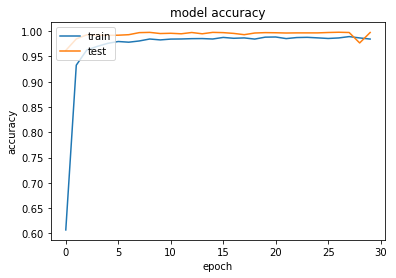

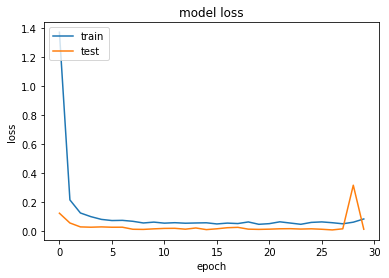

In [43]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('CNN_1-accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('CNN_1-loss.png')

In [44]:
import sys
orig_stdout = sys.stdout
f = open('Model_Summary.txt', 'w')
sys.stdout = f
print(model.summary())
sys.stdout = orig_stdout
f.close()

In [45]:
orig_stdout = sys.stdout
f = open('History.txt', 'w')
sys.stdout = f
print(history.history)
print('Test score:', score[0])
print('Test accuracy:', score[1])
sys.stdout = orig_stdout
f.close()